In [7]:
import numpy as np
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

# dataset_path = os.listdir('datasets')

# print (dataset_path)  #what kinds of classes are in this dataset

# print("Types of classes labels found: ", len(dataset_path))
dataset_dir = "datasets"
sub_dirs = ["train", "valid", "test"]
class_labels = []

# Iterate through each dataset split (train, valid, test)
for sub_dir in sub_dirs:
    sub_path = os.path.join(dataset_dir, sub_dir)
    
    for class_name in os.listdir(sub_path):  # List class folders
        class_dir = os.path.join(sub_path, class_name)
        
        # Skip non-directory files (.DS_Store)
        if not os.path.isdir(class_dir):
            continue
        
        # Get all image file names inside each class folder
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            class_labels.append((class_name, image_path))

# Build DataFrame
df = pd.DataFrame(data=class_labels, columns=['Labels', 'Image'])

# Display first and last few rows
print(df.head())
print(df.tail())

                  Labels                                              Image
0  Potato___Early_blight  datasets/train/Potato___Early_blight/bc7552e4-...
1  Potato___Early_blight  datasets/train/Potato___Early_blight/d8a8d6e5-...
2  Potato___Early_blight  datasets/train/Potato___Early_blight/d84ba2ee-...
3  Potato___Early_blight  datasets/train/Potato___Early_blight/f164ce92-...
4  Potato___Early_blight  datasets/train/Potato___Early_blight/faac446b-...
                Labels                                              Image
1495  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1496  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1497  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1498  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...
1499  Potato___healthy  datasets/test/Potato___healthy/Potato_healthy-...


In [11]:
len(df)

1500

In [21]:
import os
import cv2
import numpy as np

# Define dataset directories
dataset_dir = "datasets"
sub_dirs = ["Train", "Valid", "Test"]  # Make sure these match your actual folder names

im_size = 224
images = []
labels = []

# Loop through train, valid, test folders
for sub_dir in sub_dirs:
    sub_path = os.path.join(dataset_dir, sub_dir)

    for class_name in os.listdir(sub_path):
        class_path = os.path.join(sub_path, class_name)

        if not os.path.isdir(class_path):  # Skip .DS_Store and other non-folder files
            continue

        for img_file in os.listdir(class_path):  # Now accessing actual images
            img_path = os.path.join(class_path, img_file)

            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  
                print(f"Skipping non-image file: {img_path}")
                continue  # Skip non-image files

            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Skipping corrupted image: {img_path}")
                continue  
            
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(class_name)

# Convert images list to NumPy array
images = np.array(images)

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")


Total images loaded: 1500
Total labels loaded: 1500


In [33]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

y = df['Labels'].values
print(y)

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)


['Potato___Early_blight' 'Potato___Early_blight' 'Potato___Early_blight'
 ... 'Potato___healthy' 'Potato___healthy' 'Potato___healthy']
[0 0 0 ... 2 2 2]


In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

y = df['Labels'].values
print(y)

# Label Encoding
y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)

# Reshape for ColumnTransformer
y = y.reshape(-1, 1)

# One-Hot Encoding
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y)

print(Y[:5])  # First 5 encoded labels
print(Y[35:])  # Labels from index 35 onwards


['Potato___Early_blight' 'Potato___Early_blight' 'Potato___Early_blight'
 ... 'Potato___healthy' 'Potato___healthy' 'Potato___healthy']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [39]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.20, random_state=415)

# Inspect the shape of training and testing sets
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(1200, 224, 224, 3)
(1200, 3)
(300, 224, 224, 3)
(300, 3)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping

NUM_CLASSES = 3
IMG_SIZE = 224
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Use pre-trained EfficientNetB0 without top layers
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
x = layers.GlobalAveragePooling2D()(base_model.output)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y), validation_freq=5, callbacks=[early_stop], verbose=2)


In [184]:
hist = model.fit(train_x, train_y, epochs=3, batch_size=32, validation_data=(test_x, test_y), verbose=2)


Epoch 1/3
38/38 - 87s - 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9833 - val_loss: 0.0444
Epoch 2/3
38/38 - 97s - 3s/step - accuracy: 1.0000 - loss: 8.2008e-04 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 3/3
38/38 - 91s - 2s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 4.3006e-04


In [190]:
model.save("plant_disease_model.h5")


In [230]:

def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img = img.astype("float32") / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get the class index

    print(f"Predicted Class: {predicted_class}")

predict_image("lblight5.jpg")
class_mapping = dict(enumerate(y_labelencoder.classes_))
print(class_mapping)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Class: 0
{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}


Input image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Class: Late Blight


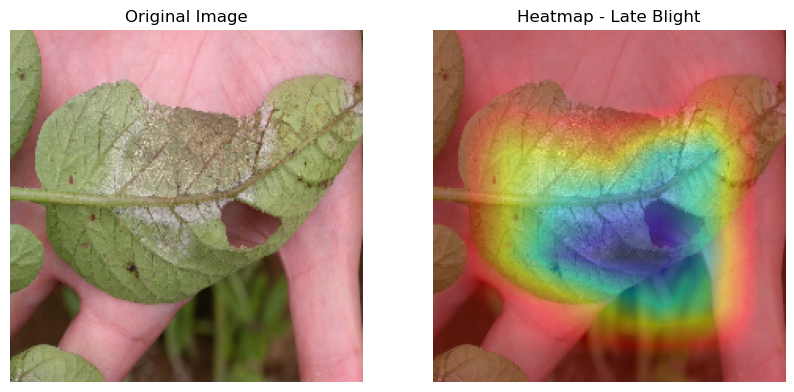

In [234]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

# Load image using OpenCV
img_path = 'lblight5.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (224, 224))  # Resize to match model input

# Preprocess image for model prediction
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

class_labels = ["Early Blight", "Late Blight", "Healthy"]

# Get model prediction
predictions = model.predict(x)  # `x` is your preprocessed input image
predicted_index = np.argmax(predictions)
predicted_class = class_labels[predicted_index]
predictions

print("Predicted Class:", predicted_class)

# ========== GRAD-CAM HEATMAP ==========
last_conv_layer = model.get_layer("top_conv") 

grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, predicted_index]

grads = tape.gradient(loss, conv_outputs)

grads = tf.reduce_mean(grads, axis=(0, 1, 2))

heatmap = np.mean(conv_outputs.numpy(), axis=-1).squeeze()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (224, 224))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Heatmap - {predicted_class}")
plt.axis("off")

plt.show()


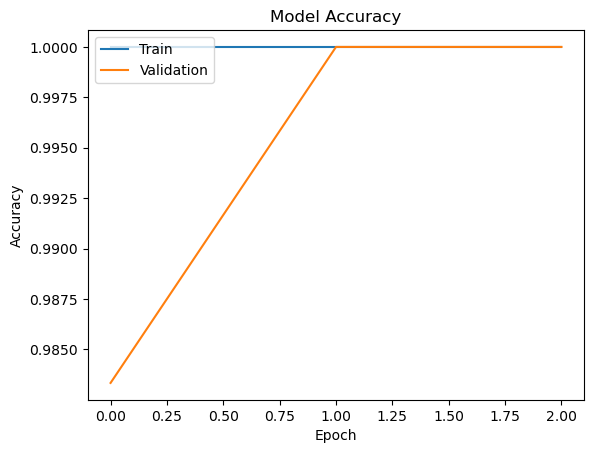

In [214]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"]) 
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

plot_hist(hist)
